# Fit simple models predicting female behavior from surrogate neural activity.

## Vanilla linear regression

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate

NTR = 276
NTRAIN = int(round(.8*NTR))
NSPLIT = 30

FIT_LIN = skl_fit_ridge
FIT_KWARGS = {'alpha': 10}

# FIT_LIN = torch_fit_lin
# FIT_KWARGS = {nepoch=500, print_every=10}

In [2]:
# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'ln'  # linear-nonlinear model
NRL_MDL = 'dyn'  # dynamical neural model

DF_BAKER_FIT_PARAM = pd.read_csv(f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv') 

ROI_SET, R_COLS_USE = 'all', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID]
# ROI_SET, R_COLS_USE = 'nonsoma', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID][DF_BAKER_FIT_PARAM.ROI != 'somas']
# ROI_SET, R_COLS_USE = 'soma', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID][DF_BAKER_FIT_PARAM.ROI == 'somas']

TARG = 'FFV'
# TARG = 'FLS'
# TARG = 'FRS'


PFX_BEHAV = f'data/simple/mlv_c/neur_basic/c_baker_{NRL_MDL}/mlv_c_baker_{NRL_MDL}'
SAVE_FILE = f'data/simple/mlv_c/neur_basic/c_baker_{NRL_MDL}_{ROI_SET}_{TARG.lower()}_{NTR}_tr.npy'

DF_BAKER_FIT_PARAM

In [ ]:
# fit regression models
rgrs = []
for csplit in range(NSPLIT):
    print(f'Split {csplit}')
    rnd_tr_idxs = np.random.permutation(NTR)
    idxs_train = rnd_tr_idxs[:NTRAIN]
    idxs_test = rnd_tr_idxs[NTRAIN:]
    rgr = FIT_LIN(PFX_BEHAV, R_COLS_USE, TARG, idxs_train, idxs_test, **FIT_KWARGS)
    rgrs.append(rgr)

Split 0
Loading...
Fitting...


In [ ]:
# save r2, weights, and example predictions
save_data = {
    'r2_train': np.array([rgr.r2_train for rgr in rgrs]),
    'r2_test': np.array([rgr.r2_test for rgr in rgrs]),
    'w': np.array([rgr.w for rgr in rgrs]),
    'ys_train': [rgr.ys_train for rgr in rgrs[:2]],
    'y_hats_train': [rgr.y_hats_train for rgr in rgrs[:2]],
    'ys_test': [rgr.ys_test for rgr in rgrs[:2]],
    'y_hats_test': [rgr.y_hats_test for rgr in rgrs[:2]],
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'nr': len(R_COLS_USE)
}

np.save(SAVE_FILE, np.array([save_data]))

In [ ]:
TRAIN_IDX_PLOT = 0
TEST_IDX_PLOT = 0

data = np.load(SAVE_FILE, allow_pickle=True)[0]
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 10), tight_layout=True)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

axs[0].hist(np.transpose([data['r2_train'], data['r2_test']]), bins=30)
axs[0].legend(['Train', 'Test'])
set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

axs[1].bar(np.arange(data['w'].shape[1]), np.mean(data['w'], axis=0))
set_plot(axs[1], x_label='Response ID', y_label='Weight', font_size=14)

axs[2].plot(np.arange(len(data['ys_train'][0][TRAIN_IDX_PLOT])), data['ys_train'][0][TRAIN_IDX_PLOT], c='k', lw=2)
axs[2].plot(np.arange(len(data['y_hats_train'][0][TRAIN_IDX_PLOT])), data['y_hats_train'][0][TRAIN_IDX_PLOT], c='r', lw=2)
axs[2].legend(['True', 'Predicted'])
set_plot(axs[2], y_lim=(-.5, 1), x_label='Timestep', y_label='FFV', title='Training data', font_size=14)

axs[3].plot(np.arange(len(data['ys_test'][0][TEST_IDX_PLOT]))/30.03, data['ys_test'][0][TEST_IDX_PLOT], c='orange', lw=2)
axs[3].plot(np.arange(len(data['y_hats_test'][0][TEST_IDX_PLOT]))/30.03, data['y_hats_test'][0][TEST_IDX_PLOT], c='k', lw=3)
axs[3].legend(['True', 'Predicted'], loc='upper left')
set_plot(axs[3], x_lim=(100, 230), y_lim=(-.5, 1), x_label='Time (s)', y_label='FFV', title='Held-out data', font_size=18)

## Ridge regression on smoothed data

In [1]:
%reset -f
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge, torch_fit_lin

cc = np.concatenate

NTR = 276
NTRAIN = int(round(.8*NTR))
NSPLIT = 30

ALPHA = .1
SMOOTH_Y = 20

FIT_LIN = skl_fit_ridge
FIT_KWARGS = {'alpha': ALPHA, 'smooth_y': SMOOTH_Y}

# FIT_LIN = torch_fit_lin
# FIT_KWARGS = {nepoch=500, print_every=10}

In [2]:
# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'ln'  # linear-nonlinear model
NRL_MDL = 'dyn'  # dynamical neural model

DF_BAKER_FIT_PARAM = pd.read_csv(f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv') 

ROI_SET, R_COLS_USE = 'all', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID]
# ROI_SET, R_COLS_USE = 'nonsoma', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID][DF_BAKER_FIT_PARAM.ROI != 'somas']
# ROI_SET, R_COLS_USE = 'soma', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID][DF_BAKER_FIT_PARAM.ROI == 'somas']

# TARG = 'FFV'
# TARG = 'FLS'
TARG = 'FRS'


PFX_BEHAV = f'data/simple/mlv_c/neur_basic/c_baker_{NRL_MDL}/mlv_c_baker_{NRL_MDL}'
SAVE_FILE = f'data/simple/mlv_c/neur_basic/c_baker_ridge_{ALPHA}_smooth_y_{SMOOTH_Y}_{NRL_MDL}_{ROI_SET}_{TARG.lower()}_{NTR}_tr.npy'

DF_BAKER_FIT_PARAM

In [4]:
# fit regression models
rgrs = []
for csplit in range(NSPLIT):
    print(f'Split {csplit}')
    rnd_tr_idxs = np.random.permutation(NTR)
    idxs_train = rnd_tr_idxs[:NTRAIN]
    idxs_test = rnd_tr_idxs[NTRAIN:]
    rgr = FIT_LIN(PFX_BEHAV, R_COLS_USE, TARG, idxs_train, idxs_test, **FIT_KWARGS)
    rgrs.append(rgr)

Split 0
Loading...
Fitting...
Scoring...
Split 1
Loading...
Fitting...
Scoring...
Split 2
Loading...
Fitting...
Scoring...
Split 3
Loading...
Fitting...
Scoring...
Split 4
Loading...
Fitting...
Scoring...
Split 5
Loading...
Fitting...
Scoring...
Split 6
Loading...
Fitting...
Scoring...
Split 7
Loading...
Fitting...
Scoring...
Split 8
Loading...
Fitting...
Scoring...
Split 9
Loading...
Fitting...
Scoring...
Split 10
Loading...
Fitting...
Scoring...
Split 11
Loading...
Fitting...
Scoring...
Split 12
Loading...
Fitting...
Scoring...
Split 13
Loading...
Fitting...
Scoring...
Split 14
Loading...
Fitting...
Scoring...
Split 15
Loading...
Fitting...
Scoring...
Split 16
Loading...
Fitting...
Scoring...
Split 17
Loading...
Fitting...
Scoring...
Split 18
Loading...
Fitting...
Scoring...
Split 19
Loading...
Fitting...
Scoring...
Split 20
Loading...
Fitting...
Scoring...
Split 21
Loading...
Fitting...
Scoring...
Split 22
Loading...
Fitting...
Scoring...
Split 23
Loading...
Fitting...
Scoring...
Sp

In [5]:
# save r2, weights, and example predictions
save_data = {
    'r2_train': np.array([rgr.r2_train for rgr in rgrs]),
    'r2_test': np.array([rgr.r2_test for rgr in rgrs]),
    'w': np.array([rgr.w for rgr in rgrs]),
    'ys_train': [rgr.ys_train for rgr in rgrs[:2]],
    'y_hats_train': [rgr.y_hats_train for rgr in rgrs[:2]],
    'ys_test': [rgr.ys_test for rgr in rgrs[:2]],
    'y_hats_test': [rgr.y_hats_test for rgr in rgrs[:2]],
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'nr': len(R_COLS_USE)
}

np.save(SAVE_FILE, np.array([save_data]))

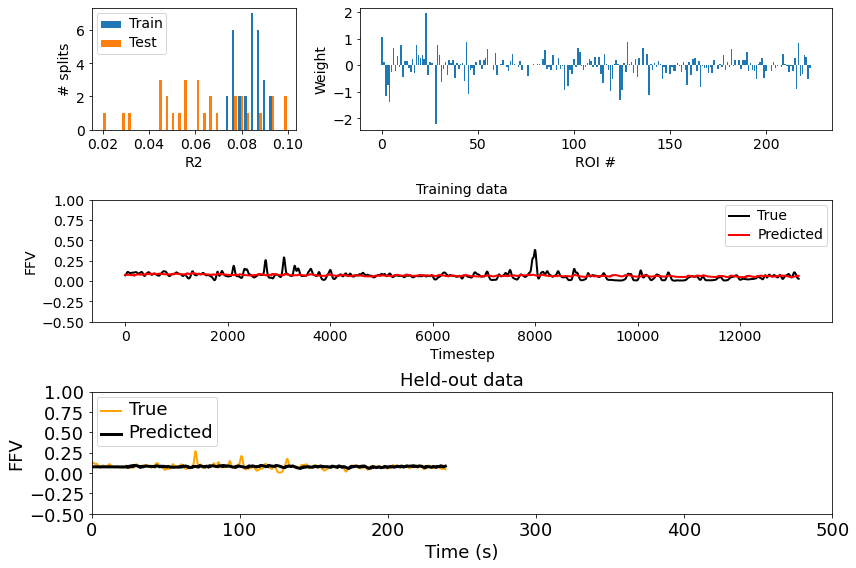

In [4]:
TRAIN_IDX_PLOT = 0
TEST_IDX_PLOT = 0

data = np.load(SAVE_FILE, allow_pickle=True)[0]
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 8), tight_layout=True)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

axs[0].hist(np.transpose([data['r2_train'], data['r2_test']]), bins=30)
axs[0].legend(['Train', 'Test'])
set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

axs[1].bar(np.arange(data['w'].shape[1]), np.mean(data['w'], axis=0))
set_plot(axs[1], x_label='ROI #', y_label='Weight', font_size=14)

axs[2].plot(np.arange(len(data['ys_train'][0][TRAIN_IDX_PLOT])), data['ys_train'][0][TRAIN_IDX_PLOT], c='k', lw=2)
axs[2].plot(np.arange(len(data['y_hats_train'][0][TRAIN_IDX_PLOT])), data['y_hats_train'][0][TRAIN_IDX_PLOT], c='r', lw=2)
axs[2].legend(['True', 'Predicted'])
set_plot(axs[2], y_lim=(-.5, 1), x_label='Timestep', y_label='FFV', title='Training data', font_size=14)

axs[3].plot(np.arange(len(data['ys_test'][0][TEST_IDX_PLOT]))/30.03, data['ys_test'][0][TEST_IDX_PLOT], c='orange', lw=2)
axs[3].plot(np.arange(len(data['y_hats_test'][0][TEST_IDX_PLOT]))/30.03, data['y_hats_test'][0][TEST_IDX_PLOT], c='k', lw=3)
axs[3].legend(['True', 'Predicted'], loc='upper left')
set_plot(axs[3], x_lim=(0, 500), y_lim=(-.5, 1), x_label='Time (s)', y_label='FFV', title='Held-out data', font_size=18)